In [1]:
DEBUG = False

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
pd.set_option("display.max_rows", 100)
import xml.etree.ElementTree as ET
import cv2
import rasterio
from rasterio.plot import show as rastershow
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("..")
from bbox.connectors import SfMComponents, BBoxComponents
from bbox.bbox_transformations import BBoxMapper, BBoxFilter
from bbox.io_utils import ParseXML, ParseYOLOCsv

In [3]:
base_path = "../data/semif-trial/reference"
connector = SfMComponents(base_path)
gcp_reference = connector.gcp_reference
camera_reference = connector.camera_reference
image_path = "../data/semif-trial/semif-trial/"
orthomosaic_path = "../data/semif-trial/images/orthomosaic.tif"
annotation_file_path = "../data/semif-trial/detections.csv"
metadata_save_path = "../data/semif-trial/metadata"
if not os.path.exists(metadata_save_path):
    os.makedirs(metadata_save_path)

In [4]:
orthomosaic = rasterio.open(orthomosaic_path)

In [5]:
# Initialize the reader which will read the annotation files and convert the bounding
# boxes to the desired format
reader = ParseYOLOCsv(image_path=image_path, label_path=annotation_file_path)

In [6]:
# Initialize the connector and get a list of all the images
box_connector = BBoxComponents(camera_reference, reader, image_path, annotation_file_path)


In [7]:
imgs = box_connector.images

Remapping bbox coordinates: 100%|███████████████| 48/48 [00:23<00:00,  2.05it/s]


In [8]:
# Map the bounding boxes from local coordinates to global coordinate system
mapper = BBoxMapper(imgs)
mapper.map()

In [9]:
# Sanity check
for img in imgs:
    for box in img.bboxes:
        assert len(box._overlapping_bboxes) == 0

In [10]:
# Apply "Non-Maxima Supression" to identify ideal boundng boxes.
# Note that the operations are done in place, i.e. imgs, which is
# a list of Image objects have BBox objects associated with them.
# The properties of these objects are changed by the BBoxFilter.
bbox_filter = BBoxFilter(imgs)
bbox_filter.deduplicate_bboxes()

In [11]:
# Save the config
for img in imgs:
    img.save_config(metadata_save_path)

In [12]:
# imgs[0].batch_metadata

In [13]:
def disp_orthomosaic():
    f, ax = plt.subplots(1, 1, dpi=200)
    rastershow(orthomosaic, ax=ax)
    plt.show()

In [14]:
# Utility plotting function to plot all the identified primary boxes
def plot_rectangle(images, display_orthomosaic=True, seed=42):
    
    import random
    random.seed(seed)
    
    image_store = {image.image_id: image for image in images}
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    
    if display_orthomosaic:
        rastershow(orthomosaic, ax=ax)
    
    bboxes_plotted = set()
    
    primary_bboxes = []
    
    for img in images:
        r, g, b = random.random(), random.random()%0.5, random.random()
        img_color = (r, g, b, 0.05)
        linewidth = 1
        
        handle = ax.scatter(img.camera_info.camera_location[0], img.camera_info.camera_location[1], marker="x", color=img_color)
        
        for bbox in img.bboxes:
            if bbox.id in bboxes_plotted:
                continue
            
            if bbox.is_primary:
                primary_bboxes.append(bbox)
            else:
                r, g, b = random.random(), random.random(), random.random()
                color = (r, g, b, 0.05)
                linewidth = 1
                
                anchor = bbox.global_coordinates.bottom_left # tuple(global_coord.bottom_left)
                width = bbox.global_coordinates.top_right[0] - bbox.global_coordinates.top_left[0]
                height = bbox.global_coordinates.top_left[1] - bbox.global_coordinates.bottom_left[1]
                patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth, linestyle="--")
                ax.add_patch(patch)

                bboxes_plotted.add(bbox.id)
    
    classes = list(set([bbox.id for bbox in primary_bboxes]))
    cls_colors = dict()
    for cls in classes:
        r, g, b = random.random(), random.random()%0.5, random.random()
        color = (r, g, b)
        cls_colors[cls] = color
    
    labels = []
    handles = []
    # Plot the primary bboxes
    for bbox in primary_bboxes:
        color = cls_colors[bbox.id]
        linewidth = 1
        
        anchor = bbox.global_coordinates.bottom_left
        width = bbox.global_coordinates.top_right[0] - bbox.global_coordinates.top_left[0]
        height = bbox.global_coordinates.top_left[1] - bbox.global_coordinates.bottom_left[1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        
        # Highlight the image fov and center
        img = image_store[bbox.image_id]
        
        handle = ax.scatter(img.camera_info.camera_location[0], img.camera_info.camera_location[1], marker="x", color=color)
        handles.append(handle)
        labels.append(bbox.id)
        
    ax.legend(handles, labels, ncol=5, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    plt.show()

In [15]:
# Utility function to plot all the bounding boxes of a single bject at a time
def plot_cls(images, cls):
    
    import random
    random.seed(424242)
    
    image_store = {image.image_id: image for image in images}
    
    f, ax = plt.subplots(1, 1, dpi=300)
    ax.set_aspect("equal", adjustable="box")
    rastershow(orthomosaic, ax=ax)
    
    bboxes_plotted = set()
    
    primary_bboxes = []
    overlapping_boxes = []
    
    for img in images:
        for bbox in img.bboxes:
            if bbox.id in bboxes_plotted:
                continue
            
            if bbox.is_primary and bbox.cls == cls:
                primary_bboxes.append(bbox)
                overlapping_boxes.append(bbox._overlapping_bboxes)
    
    handles = []
    labels = []
    for bbox, _overlapping_boxes in zip(primary_bboxes, overlapping_boxes):
        
        for box in _overlapping_boxes:
            r, g, b = random.random(), random.random(), random.random()
            color = (r, g, b)
            linewidth = 1
            
            anchor = box.global_coordinates.bottom_left
            width = box.global_coordinates.top_right[0] - box.global_coordinates.top_left[0]
            height = box.global_coordinates.top_left[1] - box.global_coordinates.bottom_left[1]
            patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth)
            ax.add_patch(patch)
            
            img = image_store[box.image_id]
            handle = ax.scatter(img.camera_info.camera_location[0], img.camera_info.camera_location[1], marker="x", color=color)
            
        
        color = (1., 0., 0.)
        linewidth = 2
        
        anchor = bbox.global_coordinates.bottom_left
        width = bbox.global_coordinates.top_right[0] - bbox.global_coordinates.top_left[0]
        height = bbox.global_coordinates.top_left[1] - bbox.global_coordinates.bottom_left[1]
        patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        
        # Highlight the image fov and center
        img = image_store[bbox.image_id]

        width = img.camera_info.fov.top_right[0] - img.camera_info.fov.top_left[0]
        height = img.camera_info.fov.top_left[1] - img.camera_info.fov.bottom_left[1]
        patch = Rectangle(img.camera_info.fov.bottom_left, width, height, facecolor="none", edgecolor=color, linewidth=1, linestyle="--")
        ax.add_patch(patch)
        
        handle = ax.scatter(img.camera_info.camera_location[0], img.camera_info.camera_location[1], marker="x", color=color)
        handles.append(handle)
        labels.append(bbox.image_id)
        
    ax.legend(handles, labels, ncol=5, loc="lower left", fontsize="xx-small", bbox_to_anchor=(0.8, 1.0))
    plt.show()

In [16]:
def plot_local(images):
    
    for img in images:
        f, ax = plt.subplots(1, 1, dpi=100)
        ax.imshow(img.array)
        
        for bbox in img.bboxes:
            anchor = bbox.local_coordinates.bottom_left
            width = bbox.local_coordinates.top_right[0] - bbox.local_coordinates.top_left[0]
            height = bbox.local_coordinates.top_left[1] - bbox.local_coordinates.bottom_left[1]
            patch = Rectangle(anchor, width, height, facecolor="none", edgecolor=(1., 0., 0.), linewidth=1)
            ax.add_patch(patch)
        ax.set_title(img.image_id)
        plt.show()
            

In [17]:
# disp_orthomosaic()

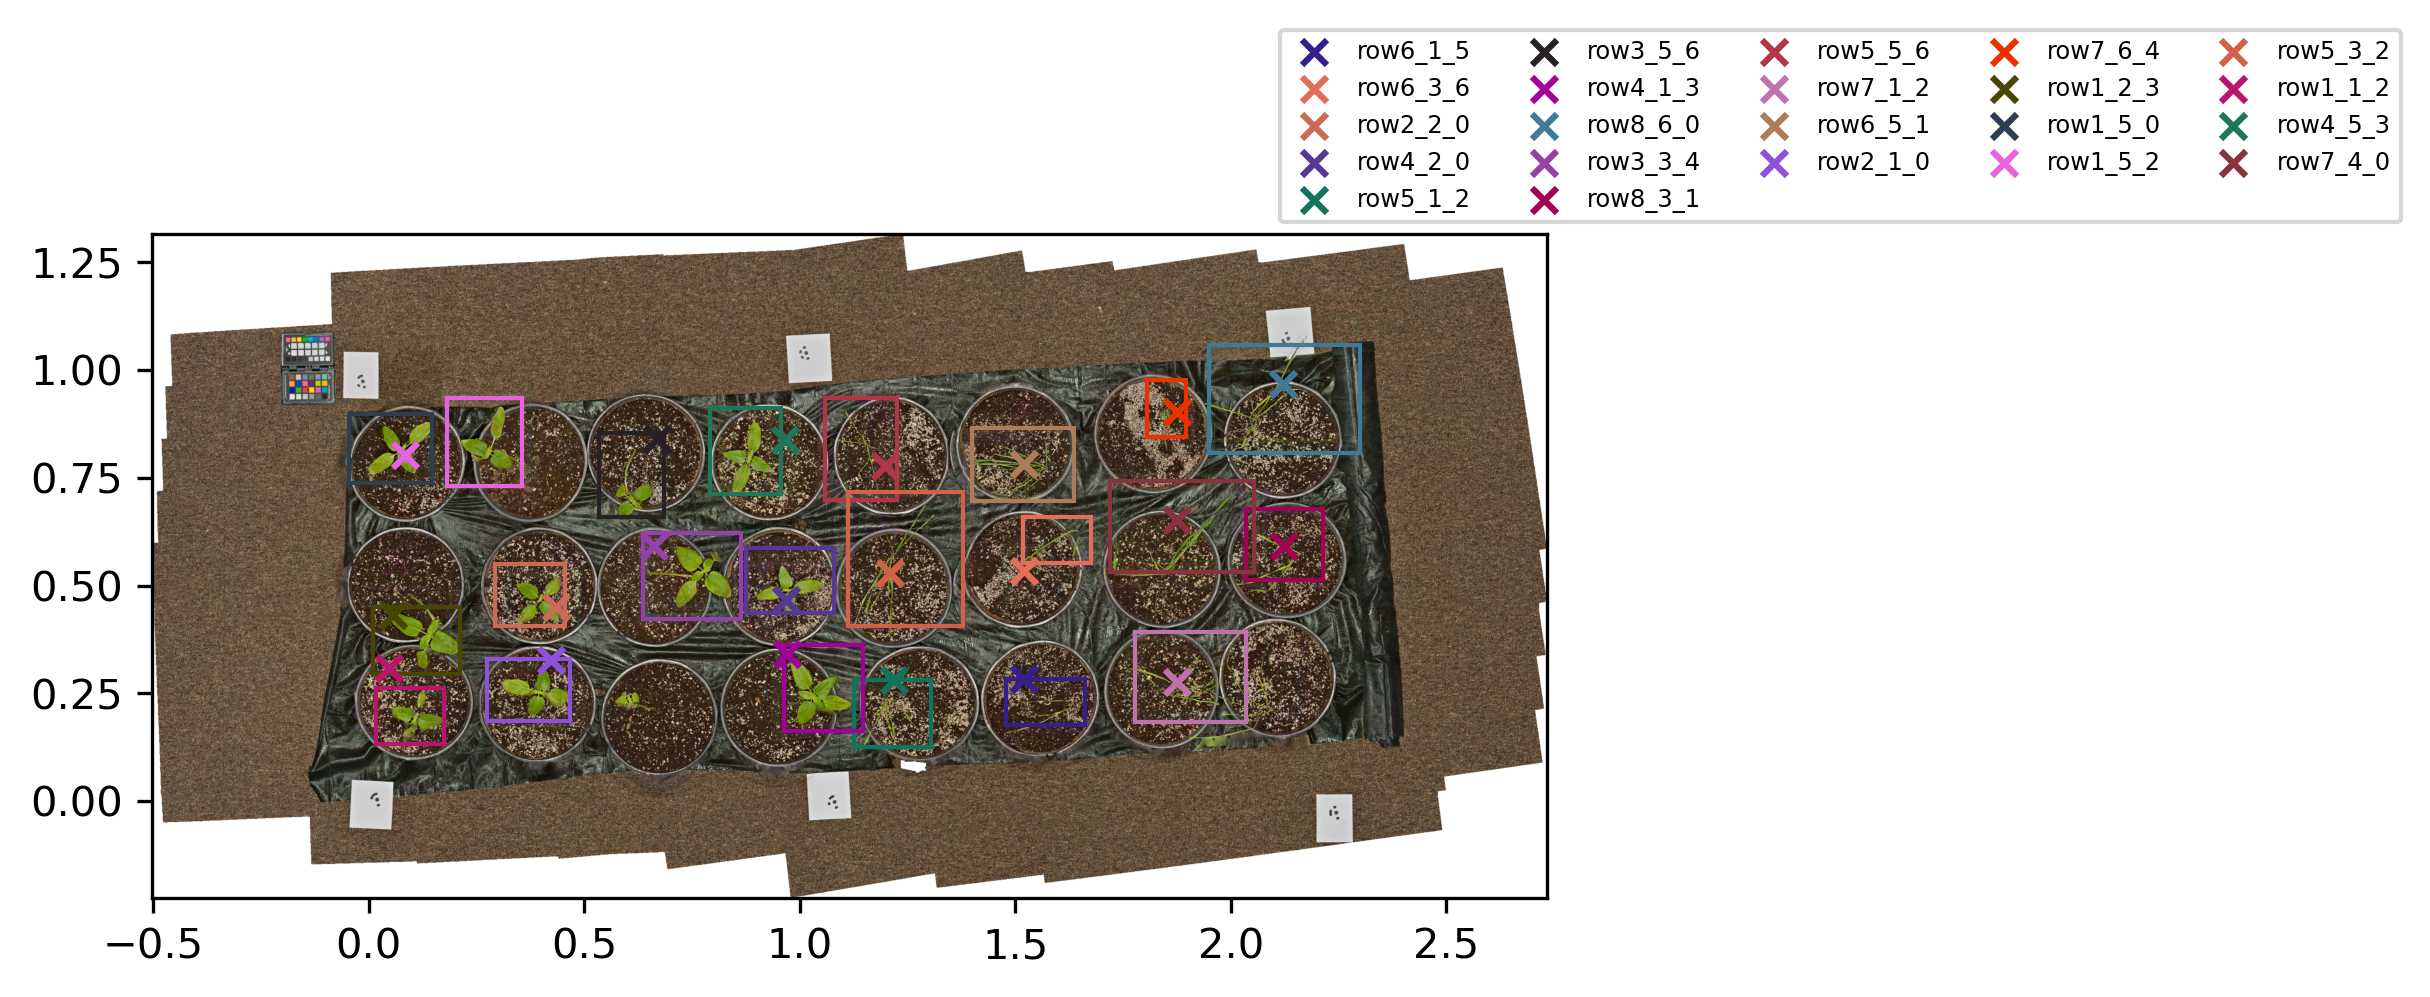

In [32]:
plot_rectangle(imgs, display_orthomosaic=True, seed=424242)

In [19]:
# imgs_to_disp = [img for img in imgs if img.image_id in ["row1_3", "row1_4", "row1_5", "row1_6", "row2_3", "row2_4", "row2_5", "row2_6"]]
# imgs_to_disp = sorted(imgs_to_disp, key=lambda img: img.image_id)
# plot_local(imgs_to_disp)

In [20]:
# plot_cls(imgs, "target 1")

In [21]:
# plot_cls(imgs, "target 2")

In [22]:
# plot_cls(imgs, "target 3")

In [23]:
# plot_cls(imgs, "target 4")

In [24]:
# plot_cls(imgs, "target 5")

In [25]:
# plot_cls(imgs, "target 6")

In [26]:
# plot_cls(imgs, "target 7")

In [27]:
# plot_cls(imgs, "target 8")

In [28]:
# plot_cls(imgs, "target 9")

In [29]:
# plot_cls(imgs, "target 10")

In [30]:
# plot_cls(imgs, "target 11")

In [31]:
# plot_cls(imgs, "target 12")